### Vehicle Detection Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import numpy as np
import cv2, glob, math

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.metrics import accuracy_score

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
# a simple timer class
from timeit import default_timer as timer
class Timer(object):
    def __init__(self, msg, fmt="%0.3g", show=True):
        self.msg = msg
        self.fmt = fmt
        self.show = show

    def __enter__(self):
        self.start = timer()
        return self

    def __exit__(self, *args):
        t = timer() - self.start
        if self.show:
            print(("%s : " + self.fmt + " seconds") % (self.msg, t))
        self.time = t

### Visualize Training Data

In [3]:
car_img_files = glob.glob('training_data/vehicles/*/*.png')
noncar_img_files = glob.glob('training_data/non-vehicles/*/*.png')

ncar_imgs = len(car_img_files)
nnoncar_imgs = len(noncar_img_files)
print ("Number of car examples: {}".format(ncar_imgs))
print ("Number of non-car examples: {}".format(nnoncar_imgs))

Number of car examples: 8792
Number of non-car examples: 8968


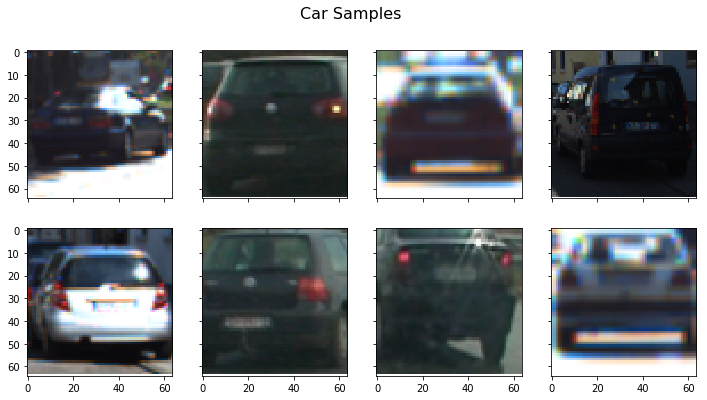

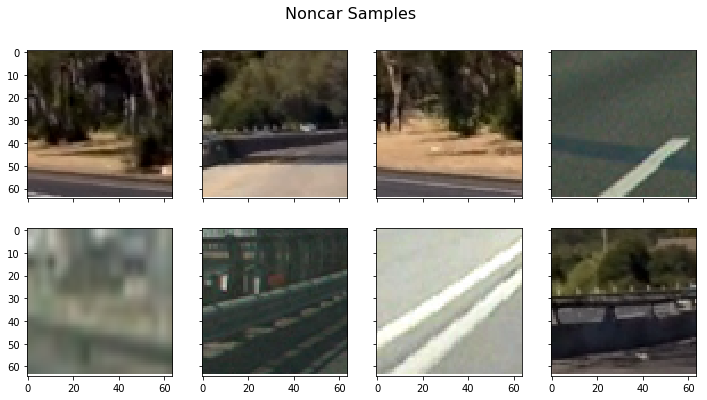

In [4]:
nsamples = 8
car_sample_files = [car_img_files[i] for i in np.random.choice(ncar_imgs, nsamples)]
noncar_sample_files = [noncar_img_files[i] for i in np.random.choice(nnoncar_imgs, nsamples)]

def plot_sample_files(fsamples, title):
    ns = len(fsamples)
    nrow = math.ceil(ns/4)
    fig, axes = plt.subplots(nrows=nrow, ncols=4, sharex=True, sharey=True, figsize=(12, 3 * nrow))
    axes = axes.flatten()
    
    for i in range(ns):
        img = mpimg.imread(fsamples[i])
        axes[i].imshow(img)
        
    plt.suptitle(title, fontsize=16)
    plt.show()

plot_sample_files(car_sample_files, "Car Samples")
plot_sample_files(noncar_sample_files, "Noncar Samples")

### Extract Features
- Spatial features
- Color features
- Histogram of Oriented Gradients features

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    
    pixels_per_cell = (pix_per_cell, pix_per_cell)
    cells_per_block = (cell_per_block, cell_per_block)
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=32,
                     hist_bins=32, hist_range=(0, 256),
                     orient=15, pix_per_cell=16, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=(spatial_size, spatial_size))
        
        # Apply color_hist() also with a color space option
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Apply get_hog_features() to get HOG features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                     orient, pix_per_cell, cell_per_block))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                            pix_per_cell, cell_per_block)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    
    # Return list of feature vectors
    return features

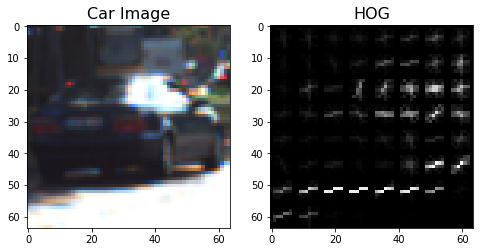

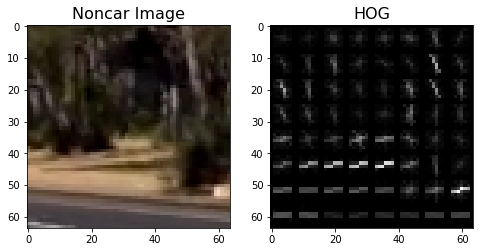

In [6]:
# Visualize hog features

orient = 15
pix_per_cell = 8
cell_per_block = 2

img_car = mpimg.imread(car_sample_files[0])
hog_features, hog_car = get_hog_features(img_car[:,:,0], orient,
                                         pix_per_cell, cell_per_block, vis=True, feature_vec=True)

img_noncar = mpimg.imread(noncar_sample_files[0])
hog_features, hog_noncar = get_hog_features(img_noncar[:,:,0], orient,
                                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)

def plot_hog(img, hog_img, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,16))
    ax1.imshow(img, cmap='gray')
    ax1.set_title(title, fontsize=16)
    ax2.imshow(hog_img, cmap='gray')
    ax2.set_title("HOG", fontsize=16)
    
plot_hog(img_car, hog_car, "Car Image")
plot_hog(img_noncar, hog_noncar, "Noncar Image")

### SVM Classifier
- Prepare labeled data: shuffle, normalize
- Train SVM

In [7]:
def car_noncar_features(car_img_files, noncar_img_files,
                        cspace='RGB', spatial_size=32, hist_bins=32, hist_range=(0, 256),
                        orient=15, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        show_time=True, keep_prob=0.5):
    ncar = int(keep_prob * len(car_img_files))
    nnoncar = int(keep_prob * len(noncar_img_files))
    
    with Timer("Extract Features", show=show_time) as t:
        car_features = extract_features(np.random.choice(car_img_files, ncar), cspace,
                                        spatial_size, hist_bins, hist_range,
                                        orient, pix_per_cell, cell_per_block, hog_channel)
        noncar_features = extract_features(np.random.choice(noncar_img_files, nnoncar), cspace,
                                           spatial_size, hist_bins, hist_range,
                                           orient, pix_per_cell, cell_per_block, hog_channel)
    return car_features, noncar_features

def split_data(car_features, noncar_features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, noncar_features)).astype(np.float64)  
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
    
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
    
    return X_train, X_test, y_train, y_test, X_scaler

def SVM_classifier(X_train, X_test, y_train, y_test, SVM_C=1.0, SVM_kernel='linear',
                   show_time=True, show_accuracy=True):
    svc = SVC(C=SVM_C, kernel=SVM_kernel)
    with Timer("SMV fitting", show=show_time) as T:
        clf = svc.fit(X_train, y_train)
    
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    if show_accuracy:
        print ("Accuracy on test set: {:.4f}".format(acc))
    
    return clf

**Feature extractions:**
- HOG features:
  - cell_per_block: 2
  - hog_channel: 0, 1, 2, ALL
  - pix_per_cell: 8, 16
  - orient: 5, 10, 15
- color spaces: RGB, HLS, YUV
- spatial size: 16, 32
- hist_bins: 16, 32, 64

**SVM parameters:**
- C: 1.0, 4.0, 8.0
- kernel: linear, rbf

In [8]:
def test_parameter(car_img_files, noncar_img_files,
                   cspace='RGB', spatial_size=32, hist_bins=32,
                   orient=15, pix_per_cell=8, hog_channel=0,
                   SVM_C=1.0, SVM_kernel='linear'):
    
    print ("{:20s} {:>8s}".format("Color Space", cspace))
    
    if hog_channel == 'ALL':
        print ("{:20s} {:>8}".format("HOG Channel", hog_channel))
    else :
        print ("{:20s} {:>8d}".format("HOG Channel", hog_channel))
    print ("{:20s} {:>8d}".format("HOG Orient", orient))
    print ("{:20s} {:>8d}".format("HOG Pixel Per Cell", pix_per_cell))
    
    print ("{:20s} {:>8d}".format("Spatial Size", spatial_size))
    print ("{:20s} {:>8d}".format("Hist Bins", hist_bins))
    
    print ("{:20s} {:>8.3f}".format("SMV C", SVM_C))
    print ("{:20s} {:>8s}".format("SMV Kernel", SVM_kernel))
    
    car_features, noncar_features = car_noncar_features(car_img_files, noncar_img_files,
                                                        cspace, spatial_size, hist_bins,
                                                        orient=orient, pix_per_cell=pix_per_cell,
                                                        hog_channel=hog_channel)
    
    X_train, X_test, y_train, y_test, X_scaler = split_data(car_features, noncar_features)
    
    clf = SVM_classifier(X_train, X_test, y_train, y_test, SVM_C, SVM_kernel)
    
    return clf, X_scaler

# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 5, 10]}
# svr = SVC()
# clf = grid_search.GridSearchCV(svr, parameters)
# clf.fit(iris.data, iris.target)

In [9]:
# HLS channels
for i in range(3):
    clf, X_scaler = test_parameter(car_img_files, noncar_img_files, cspace='HLS', hog_channel=i)

# YUV channels
for i in range(3):
    clf, X_scaler = test_parameter(car_img_files, noncar_img_files, cspace='YUV', hog_channel=i)
clf, X_scaler = test_parameter(car_img_files, noncar_img_files, cspace='YUV', hog_channel='ALL')

Color Space               HLS
HOG Channel                 0
HOG Orient                 15
HOG Pixel Per Cell          8
Spatial Size               32
Hist Bins                  32
SMV C                   1.000
SMV Kernel             linear
Extract Features : 41.4 seconds
SMV fitting : 55.3 seconds
Accuracy on test set: 0.9713
Color Space               HLS
HOG Channel                 1
HOG Orient                 15
HOG Pixel Per Cell          8
Spatial Size               32
Hist Bins                  32
SMV C                   1.000
SMV Kernel             linear
Extract Features : 37.4 seconds
SMV fitting : 43.2 seconds
Accuracy on test set: 0.9814
Color Space               HLS
HOG Channel                 2
HOG Orient                 15
HOG Pixel Per Cell          8
Spatial Size               32
Hist Bins                  32
SMV C                   1.000
SMV Kernel             linear
Extract Features : 37 seconds
SMV fitting : 61.2 seconds
Accuracy on test set: 0.9623
Color Space       

In [10]:
# test other parameters of extract features
pix_per_cell = 8
spatial_size = 32
hist_bins = 32

orient = 10
clf, X_scaler = test_parameter(car_img_files, noncar_img_files, cspace="YUV",
                               spatial_size=spatial_size, hist_bins=hist_bins,
                               pix_per_cell=pix_per_cell, orient=orient)

spatial_size = 16
clf, X_scaler = test_parameter(car_img_files, noncar_img_files, cspace="YUV",
                               spatial_size=spatial_size, hist_bins=hist_bins,
                               pix_per_cell=pix_per_cell, orient=orient)

orient = 5
clf, X_scaler = test_parameter(car_img_files, noncar_img_files, cspace="YUV",
                               spatial_size=spatial_size, hist_bins=hist_bins,
                               pix_per_cell=pix_per_cell, orient=orient)

hist_bins = 16
clf, X_scaler = test_parameter(car_img_files, noncar_img_files, cspace="YUV",
                               spatial_size=spatial_size, hist_bins=hist_bins,
                               pix_per_cell=pix_per_cell, orient=orient)

Color Space               YUV
HOG Channel                 0
HOG Orient                 10
HOG Pixel Per Cell          8
Spatial Size               32
Hist Bins                  32
SMV C                   1.000
SMV Kernel             linear
Extract Features : 38.4 seconds
SMV fitting : 39.4 seconds
Accuracy on test set: 0.9859
Color Space               YUV
HOG Channel                 0
HOG Orient                 10
HOG Pixel Per Cell          8
Spatial Size               16
Hist Bins                  32
SMV C                   1.000
SMV Kernel             linear
Extract Features : 31.6 seconds
SMV fitting : 23.3 seconds
Accuracy on test set: 0.9842
Color Space               YUV
HOG Channel                 0
HOG Orient                  5
HOG Pixel Per Cell          8
Spatial Size               16
Hist Bins                  32
SMV C                   1.000
SMV Kernel             linear
Extract Features : 27.8 seconds
SMV fitting : 13.3 seconds
Accuracy on test set: 0.9679
Color Space     

In [11]:
cspace = 'YUV'
hog_channel = 'ALL'
pix_per_cell = 8
orient = 10
spatial_size = 16
hist_bins = 32

if hog_channel == 'ALL':
    print ("{:20s} {:>8}".format("HOG Channel", hog_channel))
else :
    print ("{:20s} {:>8d}".format("HOG Channel", hog_channel))
print ("{:20s} {:>8d}".format("HOG Orient", orient))
print ("{:20s} {:>8d}".format("HOG Pixel Per Cell", pix_per_cell))

print ("{:20s} {:>8d}".format("Spatial Size", spatial_size))
print ("{:20s} {:>8d}".format("Hist Bins", hist_bins))

car_features, noncar_features = car_noncar_features(car_img_files, noncar_img_files,
                                                    cspace, spatial_size, hist_bins,
                                                    orient=orient, pix_per_cell=pix_per_cell,
                                                    hog_channel=hog_channel)
    
X_train, X_test, y_train, y_test, X_scaler = split_data(car_features, noncar_features)

# test SVM fitting parameters
SVM_C = 2.0
SVM_kernel = 'rbf'
print ("{:20s} {:>8.3f}".format("SMV C", SVM_C))
print ("{:20s} {:>8s}".format("SMV Kernel", SVM_kernel))
clf = SVM_classifier(X_train, X_test, y_train, y_test, SVM_C, SVM_kernel)

SVM_C = 2.0
SVM_kernel = 'linear'
print ("{:20s} {:>8.3f}".format("SMV C", SVM_C))
print ("{:20s} {:>8s}".format("SMV Kernel", SVM_kernel))
clf = SVM_classifier(X_train, X_test, y_train, y_test, SVM_C, SVM_kernel)

SVM_C = 1.0
SVM_kernel = 'rbf'
print ("{:20s} {:>8.3f}".format("SMV C", SVM_C))
print ("{:20s} {:>8s}".format("SMV Kernel", SVM_kernel))
clf = SVM_classifier(X_train, X_test, y_train, y_test, SVM_C, SVM_kernel)

HOG Channel               ALL
HOG Orient                 10
HOG Pixel Per Cell          8
Spatial Size               16
Hist Bins                  32
Extract Features : 51.9 seconds
SMV C                   2.000
SMV Kernel                rbf
SMV fitting : 107 seconds
Accuracy on test set: 0.9916
SMV C                   2.000
SMV Kernel             linear
SMV fitting : 46.5 seconds
Accuracy on test set: 0.9904
SMV C                   1.000
SMV Kernel                rbf
SMV fitting : 108 seconds
Accuracy on test set: 0.9916


In [25]:
# Final parameters

cspace = 'YUV'

hog_channel = 'ALL'
cell_per_block = 2
pix_per_cell = 10
orient = 8

spatial_size = 20
hist_bins = 32

if hog_channel == 'ALL':
    print ("{:20s} {:>8}".format("HOG Channel", hog_channel))
else :
    print ("{:20s} {:>8d}".format("HOG Channel", hog_channel))
print ("{:20s} {:>8d}".format("HOG Orient", orient))
print ("{:20s} {:>8d}".format("HOG Pixel Per Cell", pix_per_cell))

print ("{:20s} {:>8d}".format("Spatial Size", spatial_size))
print ("{:20s} {:>8d}".format("Hist Bins", hist_bins))

car_features, noncar_features = car_noncar_features(car_img_files, noncar_img_files,
                                                    cspace, spatial_size, hist_bins,
                                                    orient=orient, pix_per_cell=pix_per_cell,
                                                    hog_channel=hog_channel, keep_prob=0.25)

X_train, X_test, y_train, y_test, X_scaler = split_data(car_features, noncar_features)

SVM_C = 1.5
SVM_kernel = 'rbf'

print ("{:20s} {:>8.3f}".format("SMV C", SVM_C))
print ("{:20s} {:>8s}".format("SMV Kernel", SVM_kernel))
clf = SVM_classifier(X_train, X_test, y_train, y_test, SVM_C, SVM_kernel)

HOG Channel               ALL
HOG Orient                  8
HOG Pixel Per Cell         10
Spatial Size               20
Hist Bins                  32
Extract Features : 27 seconds
SMV C                   1.500
SMV Kernel                rbf
SMV fitting : 20.1 seconds
Accuracy on test set: 0.9966


### Sliding Windows

- use small window if far away from the camera

In [13]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, cspace,
              hog_channel, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    bboxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else:
        ctrans_tosearch = np.copy(img_tosearch)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=(spatial_size, spatial_size))
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,
                                                          hist_features,
                                                          hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0,0,255), 6)
                bboxes.append( ((xbox_left, ytop_draw + ystart),
                                (xbox_left + win_draw, ytop_draw + win_draw + ystart)) )
                
    return draw_img, bboxes

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

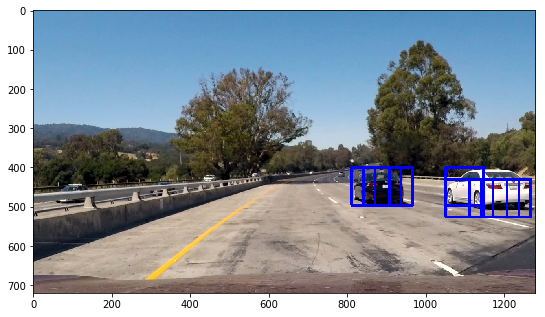

In [26]:
img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 520
scale = 1.5

out_img, bboxes = find_cars(img, ystart, ystop, scale, clf, X_scaler, cspace,
                            hog_channel, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.imshow(out_img)
plt.show()

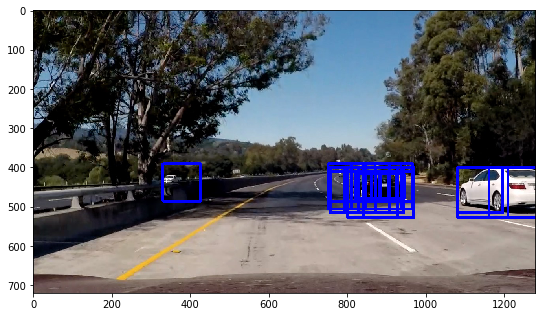

In [27]:
img = mpimg.imread('./test_images/test5.jpg')

window_triplet = [ (390, 454, 1.0), (416, 480, 1.0),
                   (390, 486, 1.5), (410, 506, 1.5), (400, 516, 1.8),
                   (400, 548, 2.0), (450, 600, 2.5),
                   (430, 630, 3.5), (464, 660, 3.5) ]

bboxes = []

for ystart, ystop, scale in window_triplet:
    out_img, bbox = find_cars(img, ystart, ystop, scale, clf, X_scaler, cspace,
                              hog_channel, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bbox)


img_bbox = draw_boxes(img, bboxes, thick=6)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.imshow(img_bbox)
plt.show()

### Create Heatmap

In [28]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

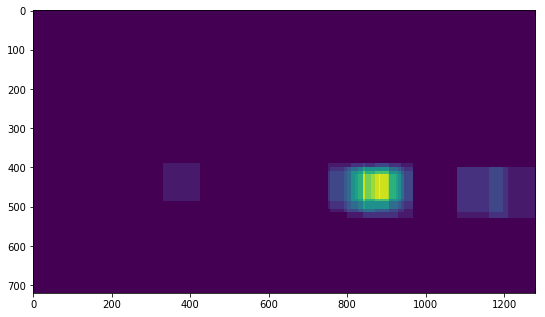

In [29]:
heatmap_img = np.zeros_like(img[:,:,0])
heatmap_img = add_heat(heatmap_img, bboxes)

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.imshow(heatmap_img)
plt.show()

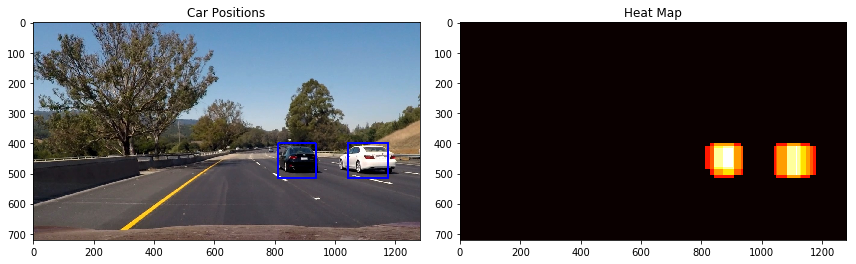

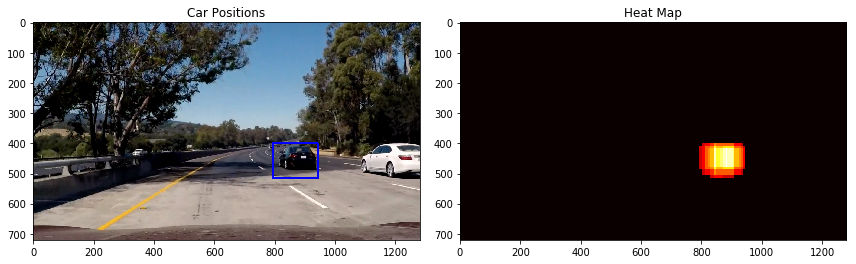

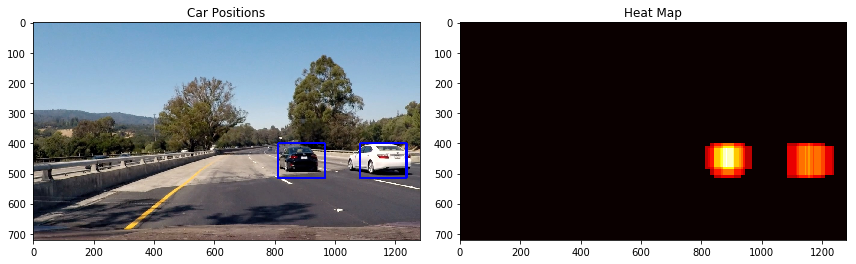

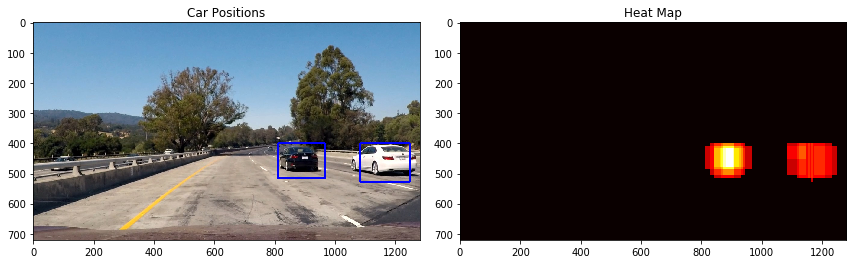

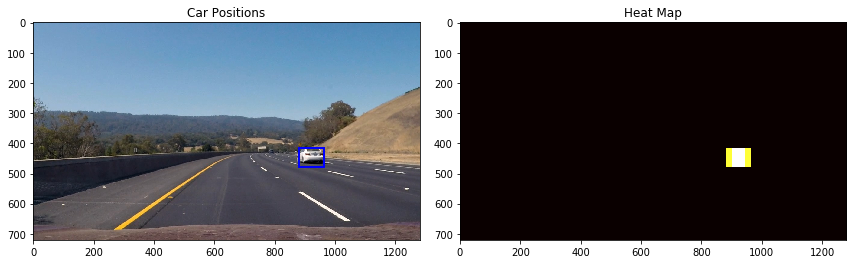

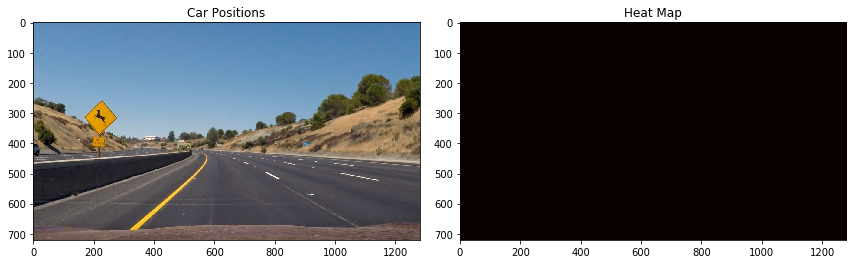

In [30]:
for f in glob.glob('./test_images/*.jpg'):
    
    img = mpimg.imread(f)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    bboxes = []

    for ystart, ystop, scale in window_triplet:
        out_img, bbox = find_cars(img, ystart, ystop, scale, clf, X_scaler, cspace,
                                  hog_channel, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bboxes.extend(bbox)


    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    fig = plt.figure(figsize=(12,9))
    ax1 = plt.subplot(121)
    ax1.imshow(draw_img)
    ax1.set_title('Car Positions')
    ax2 = plt.subplot(122)
    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('Heat Map')
    fig.tight_layout()
    plt.show()

### Pipeline

In [19]:
from collections import deque
history = deque(maxlen = 15)

def process_image(img):

    bboxes = []

    for ystart, ystop, scale in window_triplet:
        out_img, bbox = find_cars(img, ystart, ystop, scale, clf, X_scaler, cspace,
                                  hog_channel, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bboxes.extend(bbox)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, 3)
    
    heatmap_this = np.clip(heat, 0, 255)
    history.append(heatmap_this)

    heatmap = np.zeros_like(heatmap_this).astype(np.float)
    for heat in history:
        heatmap = heatmap + heat
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

def generate_video(filename):
    
    output = 'output_videos/{}'.format(filename)

    clip1 = VideoFileClip(filename)

    out_clip = clip1.fl_image(process_image)

    %time out_clip.write_videofile(output, audio=False)

In [31]:
history = deque(maxlen = 15)
generate_video("test_video.mp4")

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4


 97%|█████████▋| 38/39 [01:18<00:02,  2.13s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

CPU times: user 1min 14s, sys: 3.19 s, total: 1min 17s
Wall time: 1min 20s


In [ ]:
history = deque(maxlen = 15)
generate_video("project_video.mp4")

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


 36%|███▌      | 451/1261 [15:38<28:46,  2.13s/it]